# Livrable Algo Mardi :
( Pas totalement fonctionnel ) </br>
Seys Anthony & Prévost Louis

### Téléchargement en ligne des fichiers fits :

In [ ]:
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import pandas as pd
import os

ra = 279.23473479
dec = 38.78368896
radius = "0.01 deg"
satellite_name = "JWST"

obs = Observations.query_object(f"{ra} {dec}", radius=radius)
obs_filtered = obs[obs['obs_collection'] == satellite_name]

if len(obs_filtered) > 0:
    obs_ids = pd.Series(obs_filtered['obs_id'], dtype=str)
    prefixes = obs_ids.str.extract('(^[a-zA-Z0-9_]+)', expand=False)
    most_common_prefix = prefixes.value_counts().idxmax()

    mask = obs_ids.str.startswith(most_common_prefix).to_numpy()
    obs_filtered_by_prefix = obs_filtered[mask]

    coord = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    obs_coords = SkyCoord(obs_filtered_by_prefix['s_ra'], obs_filtered_by_prefix['s_dec'], unit=(u.deg, u.deg), frame='icrs')
    distances = coord.separation(obs_coords)

    obs_filtered_by_prefix['distance'] = distances
    obs_filtered_by_prefix_sorted = obs_filtered_by_prefix[np.argsort(obs_filtered_by_prefix['distance'])]

    download_directory = "image_test/"
    os.makedirs(download_directory, exist_ok=True)

    fits_downloaded = 0
    for obs in obs_filtered_by_prefix_sorted:
        if fits_downloaded >= 3:
            break
        try:
            product_list = Observations.get_product_list(obs)
            science_products = Observations.filter_products(product_list, productType="SCIENCE", extension="fits")
            if len(science_products) > 0:
                Observations.download_products(science_products[:3], download_dir=download_directory, cache=False)
                fits_downloaded += 1
        except Exception as e:
            pass


### Colorisation des images :

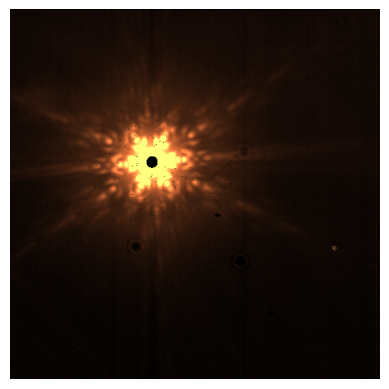

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os 

def normalisation(data, min=1, max=99):
        min = np.percentile(data, min)
        max = np.percentile(data, max)
        data_propre = np.clip(data, min, max)

        return (data_propre - min) / (max - min + 1e-8)


# J'ajoute mes 3 fichiers fits ( r g b )
rouge = fits.getdata( os.path.join('test2/jw01193026001_02101_00004_mirimage_c1000_crf.fits'))
vert = fits.getdata( os.path.join('test2/jw01193026001_02101_00004_mirimage_c1009_crf.fits'))
bleu = fits.getdata( os.path.join('test2/jw01193026001_02101_00004_mirimage_o026_crf.fits'))

# Je transforme tout les nan de mes fichiers en nombres
rouge = np.nan_to_num(rouge)
vert = np.nan_to_num(vert)
bleu = np.nan_to_num(bleu)

# Je normalise avec ma fonction pour comprendre tt les données entre 0 et 1
rouge = normalisation(rouge)
vert = normalisation(vert)
bleu = normalisation(bleu)

rouge *= 2      # On ajoutera des roue sur l'app pour modifié mais ça risque de pas être très fluide
vert *= 1
bleu *= 0.5

rouge = np.clip(rouge, 0, 1)
vert = np.clip(vert, 0, 1)
bleu = np.clip(bleu, 0, 1)


image_final = np.stack((rouge ,vert , bleu) , axis=-1)

plt.imshow(image_final)
plt.axis('off')
plt.show()